# DOE 本番解析用 (doe-2)

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [17]:
import datetime
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import griddata
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import ols

### Matplotlib の設定（オプション）

In [18]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 14

### 本日の日付を文字列で取得する関数

In [19]:
def get_date_str() -> str:
    dt = datetime.datetime.now()
    date_str = f"{dt.year:4d}-{dt.month:02d}-{dt.day:02d}"
    return date_str

### 主効果用プロット作成関数

In [20]:
def plot_main_effect(list_col, target, output):
    y_min_global = 1e7
    y_max_global = -1e7
    n = len(list_col)
    fig, ax = plt.subplots(3, 1, figsize=(6, 4 * n))
    for i, col in enumerate(list_col):
        sns.pointplot(x=col, y=target, data=df, ax=ax[i], errorbar="ci")
        y_min, y_max = ax[i].get_ylim()
        if y_min < y_min_global:
            y_min_global = y_min
        if y_max_global < y_max:
            y_max_global = y_max
        ax[i].grid()
        ax[i].set_title(f"{target}: {col}")

    for i in range(n):
        ax[i].set_ylim(y_min_global, y_max_global)

    plt.tight_layout()
    plt.savefig(output)
    plt.show()

### 交互作用プロット作成関数

In [21]:
def plot_interaction(pairs, target, output):
    n = len(pairs)
    if n > 1:
        fig, ax = plt.subplots(len(pairs), 1, figsize=(6, n * 4))
        y_min_all = 1e6
        y_max_all = -1e6
        for i, (a, b) in enumerate(pairs):
            sns.pointplot(
                x=a,
                y=target,
                hue=b,
                data=df,
                markersize=6,
                linewidth=1,
                errorbar=None,
                palette="Set2",
                ax=ax[i],
            )
            ax[i].set_title(f"{target}: {a} × {b}")
            ax[i].set_xlabel(a)
            ax[i].set_ylabel(target)
            # 凡例のタイトル
            lg = ax[i].legend(fontsize=7)
            lg.set_title(b, prop={"size": 7})

            ax[i].grid()

            # y 軸の最大値・最小値
            y_min, y_max = ax[i].get_ylim()
            if y_min < y_min_all:
                y_min_all = y_min
            if y_max_all < y_max:
                y_max_all = y_max

        # y 軸の範囲を揃える
        for i in range(n):
            ax[i].set_ylim(y_min_all, y_max_all)
    else:
        a, b = pairs[0]
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        sns.pointplot(
            x=a,
            y=target,
            hue=b,
            data=df,
            markersize=6,
            linewidth=1,
            errorbar=None,
            palette="Set2",
            ax=ax,
        )
        ax.set_title(f"{target}: {a} × {b}")
        ax.set_xlabel(a)
        ax.set_ylabel(target)
        # 凡例のタイトル
        lg = ax.legend(fontsize=7)
        lg.set_title(b, prop={"size": 7})
        ax.grid()

    plt.tight_layout()
    plt.savefig(output)
    plt.show()

### 等高線図作成関数

In [22]:
def plot_contour(col_x: str, col_y: str, col_z: str, output: str):
    x = df[col_x]
    y = df[col_y]
    z = df[col_z]

    # グリッド作成
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    Xi, Yi = np.meshgrid(xi, yi)
    # 補間
    Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

    fig, ax = plt.subplots(figsize=(6, 6))

    cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm")
    ax.clabel(cont, inline=True, fontsize=12)
    # ✅ 元データ点を黒丸で追加
    ax.scatter(x, y, color="black", s=8, zorder=3)

    y_min, y_max = ax.get_ylim()
    if y_max < 10:
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:4,.1f}"))
    else:
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:4,.0f}"))
    ax.set_title(f"{target}: {col_x} × {col_y}")
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)

    ax.grid(True, color="gray", linestyle="dotted", linewidth=0.5)
    plt.savefig(output)
    plt.show()

## CSV ファイルの読込

In [23]:
name_doe = "doe-2"
name_code = "7011"
# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))
print(list_file)
list_df = list()
for file in list_file:
    path = os.path.join(path_dir, file)
    list_df.append(pd.read_csv(path))
n_tick = len(list_df)
df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
df

['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv', 'ticks_20250925.csv', 'ticks_20250926.csv', 'ticks_20250929.csv', 'ticks_20250930.csv', 'ticks_20251001.csv', 'ticks_20251002.csv', 'ticks_20251003.csv', 'ticks_20251006.csv', 'ticks_20251007.csv', 'ticks_20251008.csv', 'ticks_20251009.csv', 'ticks_20251010.csv', 'ticks_20251014.csv', 'ticks_20251015.csv', 'ticks_20251016.csv', 'ticks_20251017.csv', 'ticks_20251020.csv', 'ticks_20251021.csv', 'ticks_20251022.csv', 'ticks_20251023.csv', 'ticks_20

,file,code,trade,PERIOD_MA_1,PERIOD_MA_2,THRESHOLD_MR,total
0,ticks_20250819.xlsx,7011,82,60,300,3,53.0
1,ticks_20250819.xlsx,7011,68,90,300,3,87.0
2,ticks_20250819.xlsx,7011,56,120,300,3,130.0
3,ticks_20250819.xlsx,7011,28,60,600,3,116.0
4,ticks_20250819.xlsx,7011,26,90,600,3,108.0
...,...,...,...,...,...,...,...
1993,ticks_20251205.xlsx,7011,12,90,600,7,-26.0
1994,ticks_20251205.xlsx,7011,10,120,600,7,-12.0
1995,ticks_20251205.xlsx,7011,12,60,900,7,-34.0
1996,ticks_20251205.xlsx,7011,12,90,900,7,-38.0


## 簡単なサマリ集計

In [24]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "THRESHOLD_MR"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()

# print(df_summary)
# html = df_summary.to_html(index=False)
# print(html)
styled = df_summary.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()

with open("summary.html", "w", encoding="utf-8") as f:
    f.write(html)

## 【収益】分散分析 (ANOVA)

In [25]:
# オリジナルのデータフレームをコピーして利用
df_anova = df.copy()

# 因子列と応答変数
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "THRESHOLD_MR"]
X = df_anova[factor_cols]
y = df_anova["total"]

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=factor_cols)

# 標準化した因子を df に置き換え
for col in factor_cols:
    df_anova[col] = X_scaled_df[col]

# 二次交互作用まで含めるモデル
formula = (
    "total ~ PERIOD_MA_1 + PERIOD_MA_2 + THRESHOLD_MR "
    "+ PERIOD_MA_1:PERIOD_MA_2 + PERIOD_MA_1:THRESHOLD_MR + PERIOD_MA_2:THRESHOLD_MR"
)
model_2way = ols(formula, data=df_anova).fit()

# ANOVAテーブル
anova_table = sm.stats.anova_lm(model_2way, typ=2)
print(f"# of tick files : {n_tick}")
print("=== ANOVA (up to 2-way interactions) ===")
print(anova_table)

# of tick files : 74
=== ANOVA (up to 2-way interactions) ===
                                sum_sq      df         F    PR(>F)
PERIOD_MA_1               1.644444e+01     1.0  0.004300  0.947720
PERIOD_MA_2               1.865633e+04     1.0  4.878913  0.027300
THRESHOLD_MR              9.323255e+03     1.0  2.438173  0.118573
PERIOD_MA_1:PERIOD_MA_2   2.677662e+03     1.0  0.700249  0.402800
PERIOD_MA_1:THRESHOLD_MR  5.455135e+02     1.0  0.142660  0.705691
PERIOD_MA_2:THRESHOLD_MR  2.648930e+02     1.0  0.069274  0.792425
Residual                  7.613324e+06  1991.0       NaN       NaN


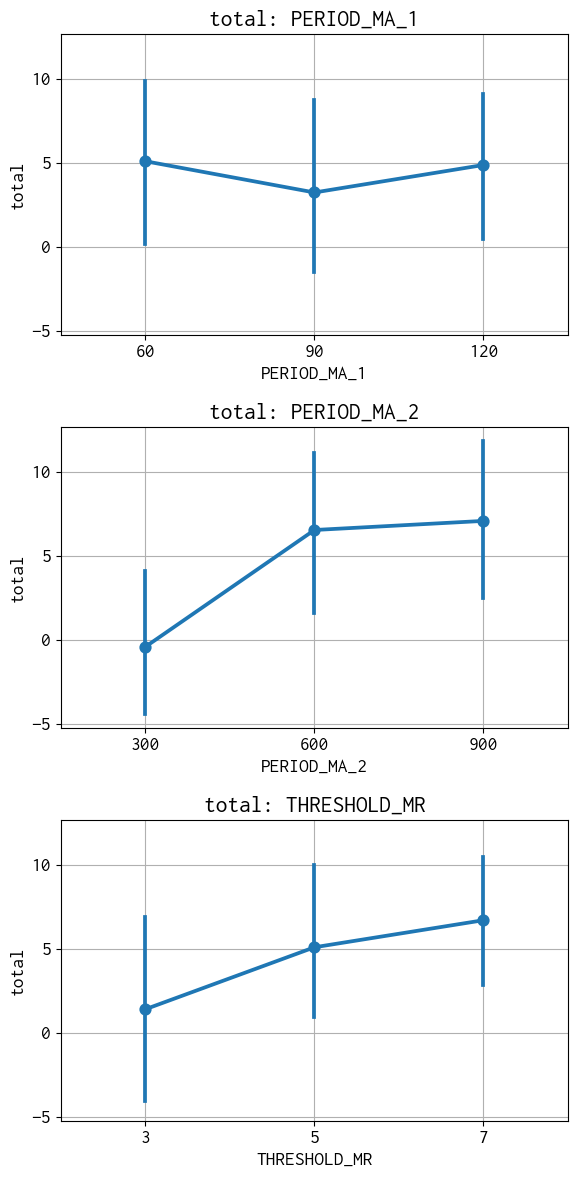

In [26]:
# === 各因子の平均効果を可視化 ===
list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "THRESHOLD_MR"]
target = "total"
date_str = get_date_str()
output = os.path.join(
    "..", "output", name_doe, f"{name_code}_doe_effects_main_{target}_{date_str}.png"
)

plot_main_effect(list_col, target, output)

## 【収益】主効果＋交互作用 プロット

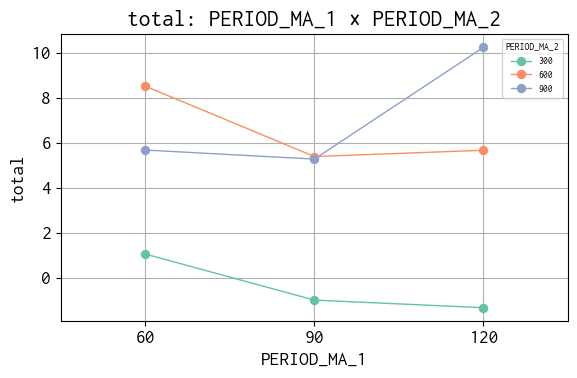

In [27]:
target = "total"
date_str = get_date_str()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{name_code}_doe_effects_interaction_{target}_{date_str}.png",
)
# print(output)
pairs = [
    ("PERIOD_MA_1", "PERIOD_MA_2"),
]
plot_interaction(pairs, target, output)

## 【収益】交互作用の等高線図

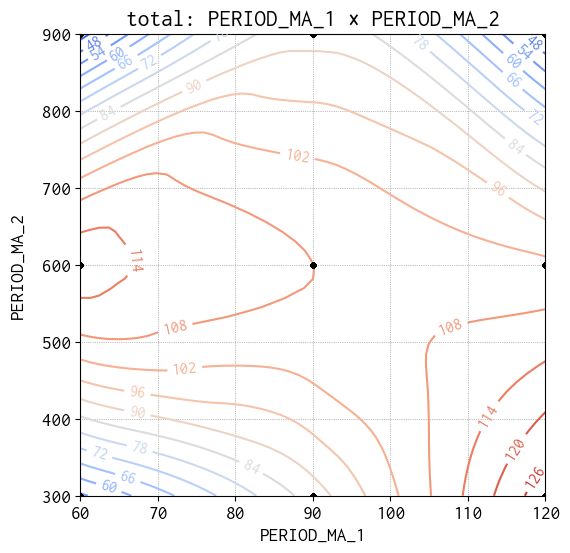

'\nplot_contour("PERIOD_MA_1", "THRESHOLD_MR", target, output)\n# ===== 3. "PERIOD_MA_2" × THRESHOLD_MR =====\noutput = os.path.join(\n    "..", "output", name_doe, f"{name_code}_doe_contour_3_{target}_{date_str}.png"\n)\nplot_contour("PERIOD_MA_2", "THRESHOLD_MR", target, output)\n'

In [28]:
target = "total"
# ===== 1. PERIOD_MA_1 × PERIOD_MA_2 =====
output = ""
output = os.path.join(
    "..", "output", name_doe, f"{name_code}_doe_contour_1_{target}_{date_str}.png"
)
plot_contour("PERIOD_MA_1", "PERIOD_MA_2", target, output)
# ===== 2. "PERIOD_MA_1" × THRESHOLD_MR =====
output = os.path.join(
    "..", "output", name_doe, f"{name_code}_doe_contour_2_{target}_{date_str}.png"
)
"""
plot_contour("PERIOD_MA_1", "THRESHOLD_MR", target, output)
# ===== 3. "PERIOD_MA_2" × THRESHOLD_MR =====
output = os.path.join(
    "..", "output", name_doe, f"{name_code}_doe_contour_3_{target}_{date_str}.png"
)
plot_contour("PERIOD_MA_2", "THRESHOLD_MR", target, output)
"""

## 【収益】重回帰分析 (MULREG)

In [29]:
# ---------------------------------------------------------
# 2. RSM 用の二次モデルを構築
#    total ~ PERIOD_MA_1 + PERIOD_MA_2 + 交互作用 + 二乗項
# ---------------------------------------------------------
formula = """
total ~ PERIOD_MA_1 + PERIOD_MA_2
        + I(PERIOD_MA_1**2) + I(PERIOD_MA_2**2)
        + PERIOD_MA_1:PERIOD_MA_2
"""

model = smf.ols(formula, data=df_summary).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     7.314
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           0.000416
Time:                        09:40:37   Log-Likelihood:                -66.099
No. Observations:                  27   AIC:                             144.2
Df Residuals:                      21   BIC:                             152.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [30]:
# ---------------------------------------------------------
# 3. 予測用のグリッドを作成して応答曲面を描く準備
# ---------------------------------------------------------
ma1_range = np.linspace(
    df_summary["PERIOD_MA_1"].min(), df_summary["PERIOD_MA_1"].max(), 100
)
ma2_range = np.linspace(
    df_summary["PERIOD_MA_2"].min(), df_summary["PERIOD_MA_2"].max(), 100
)

MA1, MA2 = np.meshgrid(ma1_range, ma2_range)

grid = pd.DataFrame({"PERIOD_MA_1": MA1.ravel(), "PERIOD_MA_2": MA2.ravel()})

grid["pred"] = model.predict(grid)

### 3D 応答曲面プロット

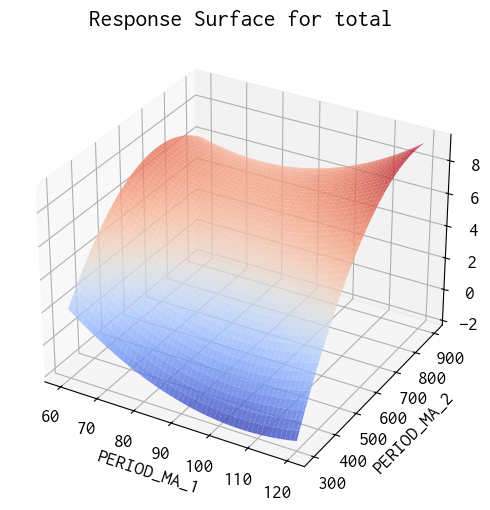

In [31]:
# ---------------------------------------------------------
# 4. 3D 応答曲面プロット（matplotlib）
# ---------------------------------------------------------
fig = plt.figure(figsize=(6, 6))
#plt.subplots_adjust(right=0.7)
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    MA1, MA2, grid["pred"].values.reshape(MA1.shape), cmap="coolwarm", alpha=0.8
)

ax.set_xlabel("PERIOD_MA_1")
ax.set_ylabel("PERIOD_MA_2")
#ax.set_zlabel("Predicted total")
ax.set_title("Response Surface for total")

output = os.path.join(
    "..", "output", name_doe, f"{name_code}_rsm_surface_1_{target}_{date_str}.png"
)

plt.show()

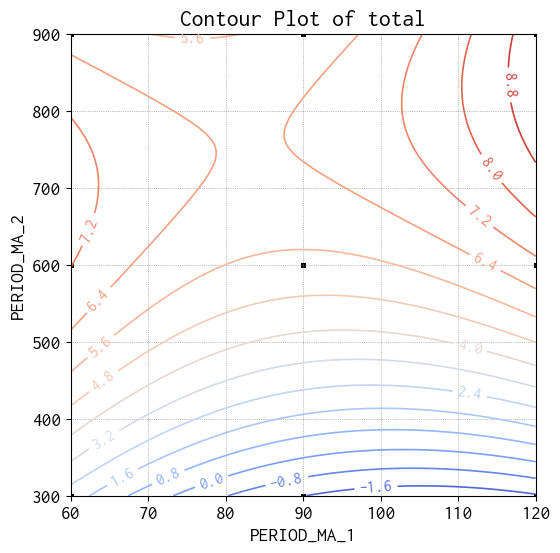

In [33]:
# ---------------------------------------------------------
# グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.figure(figsize=(6, 6))

Z = grid["pred"].values.reshape(MA1.shape)

# カラーマップを指定（viridis, plasma, inferno, cividis など）
cmap = plt.cm.coolwarm

# 等高線（線にグラデーション）
cs = plt.contour(MA1, MA2, Z, levels=15, cmap=cmap, linewidths=1.2)  # ← ここがポイント

# ---------------------------------------------------------
# 実験点を黒点で追加
# ---------------------------------------------------------
plt.scatter(
    df["PERIOD_MA_1"], df["PERIOD_MA_2"], color="black", s=5, alpha=0.9  # 点の大きさ
)

# 数値ラベル
plt.clabel(cs, inline=True, fontsize=12, fmt="%.1f")

plt.xlabel("PERIOD_MA_1")
plt.ylabel("PERIOD_MA_2")
plt.title("Contour Plot of total")
plt.grid(True, color="gray", linestyle="dotted", linewidth=0.5)

output = os.path.join(
    "..", "output", name_doe, f"{name_code}_rsm_contour_1_{target}_{date_str}.png"
)

plt.savefig(output)
plt.show()

## 【取引回数】分散分析 (ANOVA)

In [13]:
# オリジナルのデータフレームをコピーして利用
df_anova = df.copy()

# 因子列と応答変数
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "THRESHOLD_MR"]
X = df_anova[factor_cols]
y = df_anova["trade"]

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=factor_cols)

# 標準化した因子を df に置き換え
for col in factor_cols:
    df_anova[col] = X_scaled_df[col]

# 二次交互作用まで含めるモデル
formula = (
    "trade ~ PERIOD_MA_1 + PERIOD_MA_2 + THRESHOLD_MR "
    "+ PERIOD_MA_1:PERIOD_MA_2 + PERIOD_MA_1:THRESHOLD_MR + PERIOD_MA_2:THRESHOLD_MR"
)
model_2way = ols(formula, data=df_anova).fit()

# ANOVAテーブル
anova_table = sm.stats.anova_lm(model_2way, typ=2)
print(f"# of tick files : {n_tick}")
print("=== ANOVA (up to 2-way interactions) ===")
print(anova_table)

# of tick files : 74
=== ANOVA (up to 2-way interactions) ===
                                 sum_sq      df            F        PR(>F)
PERIOD_MA_1                38681.444444     1.0   158.214812  5.715306e-35
PERIOD_MA_2               114654.777778     1.0   468.960878  1.471436e-93
THRESHOLD_MR              693996.408408     1.0  2838.583541  0.000000e+00
PERIOD_MA_1:PERIOD_MA_2        3.045045     1.0     0.012455  9.111508e-01
PERIOD_MA_1:THRESHOLD_MR    5946.851351     1.0    24.323807  8.817896e-07
PERIOD_MA_2:THRESHOLD_MR   36459.572072     1.0   149.126912  3.988581e-33
Residual                  486773.360360  1991.0          NaN           NaN


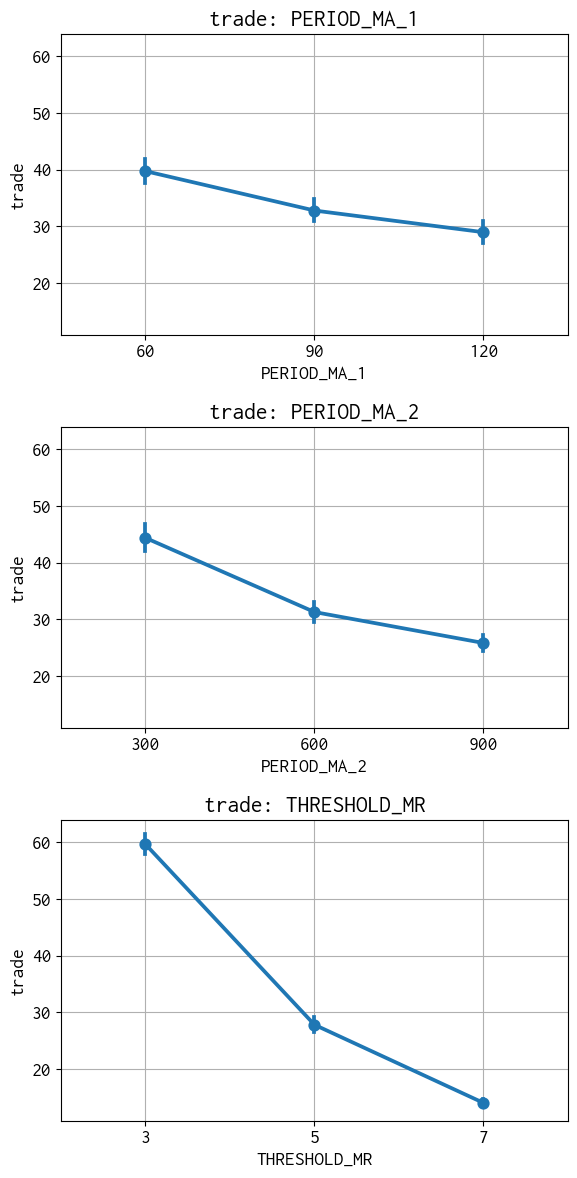

In [14]:
# === 各因子の平均効果を可視化 ===
list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "THRESHOLD_MR"]
target = "trade"
date_str = get_date_str()
output = os.path.join(
    "..", "output", name_doe, f"{name_code}_doe_effects_main_{target}_{date_str}.png"
)

plot_main_effect(list_col, target, output)

## 【取引回数】主効果＋交互作用 プロット

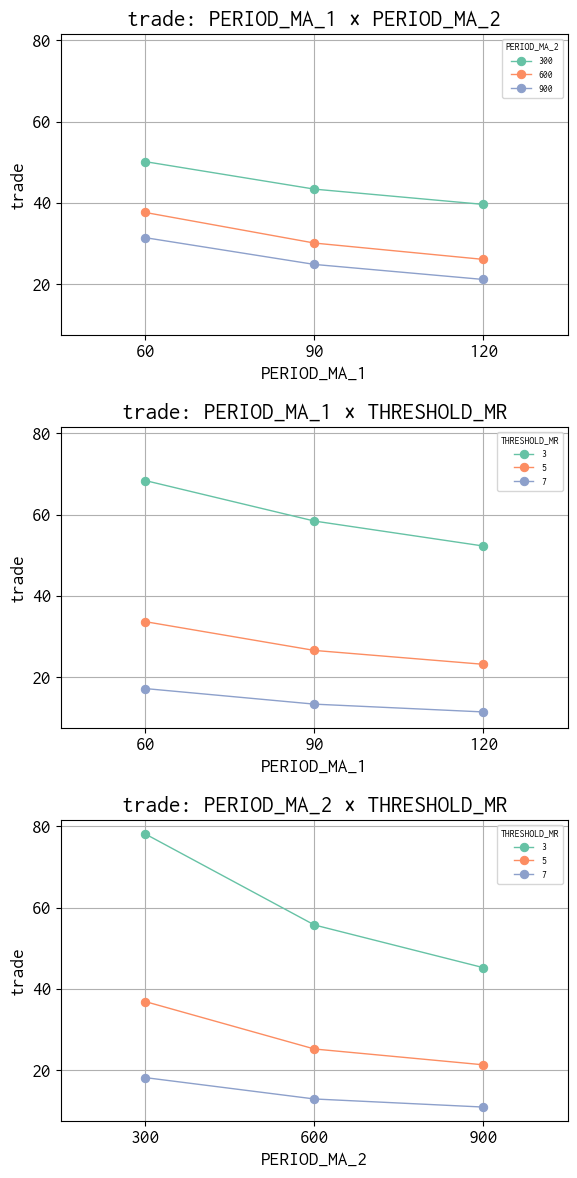

In [15]:
target = "trade"
date_str = get_date_str()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{name_code}_doe_effects_interaction_{target}_{date_str}.png",
)
# print(output)
pairs = [
    ("PERIOD_MA_1", "PERIOD_MA_2"),
    ("PERIOD_MA_1", "THRESHOLD_MR"),
    ("PERIOD_MA_2", "THRESHOLD_MR"),
]
plot_interaction(pairs, target, output)

## 【取引回数】交互作用の等高線図

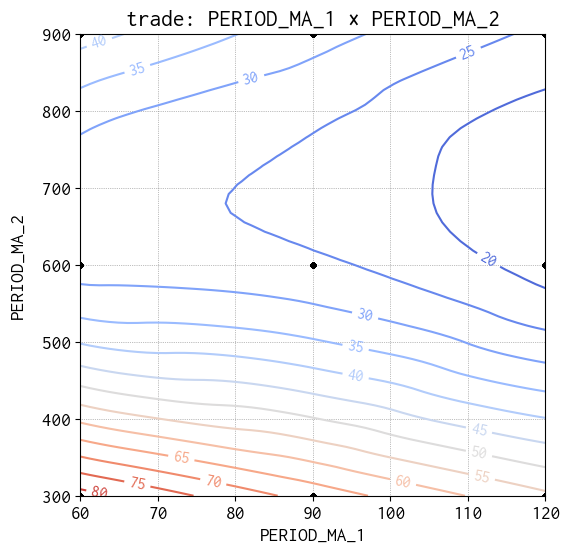

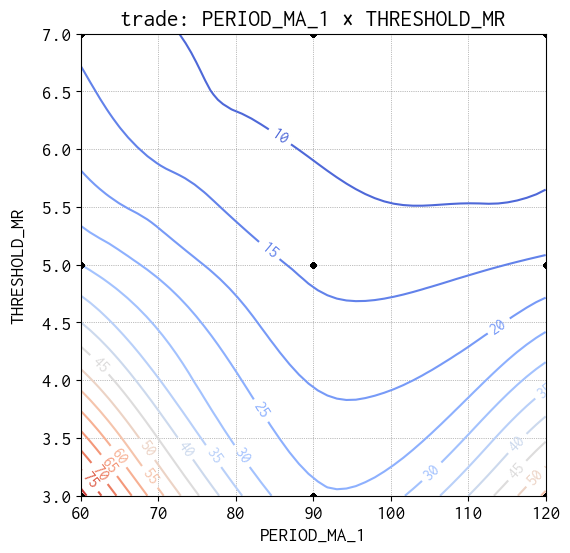

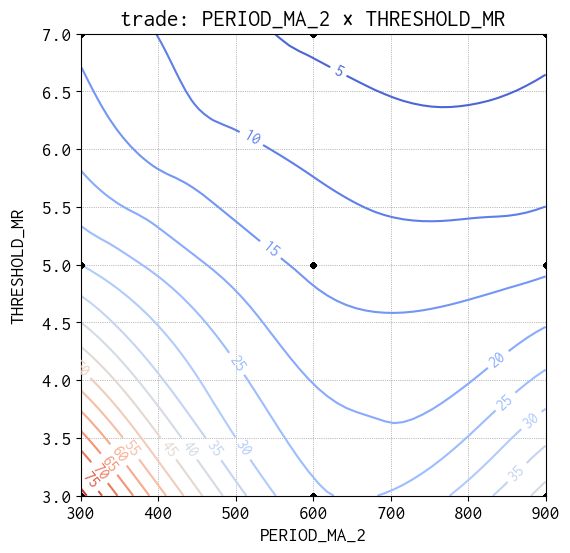

In [16]:
target = "trade"
# ===== 1. PERIOD_MA_1 × PERIOD_MA_2 =====
output = ""
output = os.path.join(
    "..", "output", name_doe, f"{name_code}_doe_contour_1_{target}_{date_str}.png"
)
plot_contour("PERIOD_MA_1", "PERIOD_MA_2", target, output)
# ===== 2. PERIOD_MA_1 × THRESHOLD_MR =====
output = os.path.join(
    "..", "output", name_doe, f"{name_code}_doe_contour_2_{target}_{date_str}.png"
)
plot_contour("PERIOD_MA_1", "THRESHOLD_MR", target, output)
# ===== 3. PERIOD_MA_2 × THRESHOLD_MR =====
output = os.path.join(
    "..", "output", name_doe, f"{name_code}_doe_contour_3_{target}_{date_str}.png"
)
plot_contour("PERIOD_MA_2", "THRESHOLD_MR", target, output)